# Example on Navier Stokes

This example uses the elixer script from: 

https://github.com/trixi-framework/Trixi.jl/blob/main/examples/dgmulti_2d/elixir_navierstokes_convergence.jl

This notebook is based on a simple Navier-Stokes problem with periodic bondary conditions in the x-direction and walls in the y-direction. The top y-boundary has a moving wall (No-Slip). This is called Couette Flow which is described in this wikipedia article: 

https://en.wikipedia.org/wiki/Couette_flow

In [1]:
VERSION

v"1.10.5"

In [2]:
] activate .

  Activating new project at `~/TRIXI`


In [3]:
using OrdinaryDiffEq
using Trixi
using Plots

# Navier Stokes Equations

In the Trixi.jl documentation, the 2D Navier-Stokes equations are written in the following form: 

\begin{equation}
    \frac{\partial}{\partial t} \begin{pmatrix}
    \rho \\
    \rho \mathbf{u} \\
    \rho e
    \end{pmatrix} + \nabla \cdot \begin{pmatrix}
    \rho \mathbf{u}\\
    \rho \mathbf{u} \mathbf{u}^{T} + p \underline{\mathbf{I}} \\
    \left( \rho e + p \right) \mathbf{u}
    \end{pmatrix} = \nabla \cdot \begin{pmatrix}
    0\\
    \underline{\mathbf{\tau}} \\
    \underline{\mathbf{\tau}} \mathbf{u} - \mathbf{q}
    \end{pmatrix}
\end{equation}

Where the left-hand-side (LHS) is just the compressible Euler gas equations. The right-hand-side (RHS) is the viscous and heatflux source terms that make the compressible Navier-Stokes equations for fluids. 

Where we define the viscous stress tensor as: 

\begin{equation}
    \underline{\mathbf{\tau}} = \begin{bmatrix}
    \tau_{11} & \tau_{12} \\
    \tau_{21} & \tau_{22}
    \end{bmatrix} = \mu \left( \nabla \mathbf{v} + \left( \mathbf{v} \right)^{T} \right) - \frac{2}{3} \mu \left( \nabla \cdot \mathbf{v} \right) \underline{\mathbf{I}}
\end{equation}

\begin{equation}
    \tau_{11} = \mu \left(  2 \frac{\partial u}{\partial x} - \frac{2}{3}  \frac{\partial u}{\partial x} \right) = \frac{4}{3} \mu \frac{\partial u}{\partial x}
\end{equation}

\begin{equation}
    \tau_{12} = \tau_{21} =\mu \left(  \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}  \right)  
\end{equation}

\begin{align}
    \tau_{22} = \mu \left(  2 \frac{\partial v}{\partial y} - \frac{2}{3}  \frac{\partial v}{\partial y} \right) = \frac{4}{3} \mu \frac{\partial v}{\partial y}
\end{align}



and the heat flux is: 

\begin{equation}
    \mathbf{q} = \begin{pmatrix}
    q_{x}\\
    q_{y}
    \end{pmatrix} = - \kappa \nabla \left( T \right) = -\kappa \begin{pmatrix}
    \partial_{x} T\\
    \partial_{y} T
    \end{pmatrix}
\end{equation}

where $\kappa$ is the thermal conductivity for Fick's law and the temperature is defined by:

\begin{equation}
    T = \frac{p}{R\rho}
\end{equation}

under the assumotion that the gas has a constant Prandtl number ( $\mathrm{Pr}$ ), the thermal conductivity is: 

\begin{equation}
    \kappa = \frac{\gamma \mu R}{\left( \gamma - 1 \right) \mathrm{Pr}}
\end{equation}

The thermal conductivity can then be defined as: 

\begin{equation}
    \mathbf{q} = \frac{\gamma \mu }{\left( \gamma - 1 \right) \mathrm{Pr}} \begin{pmatrix}
    \partial_{x} \left( p / \rho \right) \\
    \partial_{y} \left( p / \rho \right)
    \end{pmatrix}
\end{equation}

We can re-write the NS equation in explicit terms as follows: 

\begin{equation}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}
    \rho \\
    \rho u \\
    \rho v \\
    \rho E
    \end{array}\right] + \frac{\partial}{\partial x} \left[ \begin{array}{cc}
    \rho u\\
    \rho u^2 + p \\
    \rho u v \\
    u (\rho E + p)
    \end{array}\right]+ \frac{\partial}{\partial y} \left[ \begin{array}{cc}
    \rho v\\
    \rho u v \\
    \rho v^2 + p \\
    v (\rho E + p)
    \end{array}\right] =  \left[ \begin{array}{cc}
    0\\
    \frac{\partial \tau_{11}}{\partial x} + \frac{\partial \tau_{12}}{\partial y} \\
    \frac{\partial \tau_{21}}{\partial x} + \frac{\partial \tau_{22}}{\partial y} \\
    \frac{\partial \tau_{31}}{\partial x} + \frac{\partial \tau_{32}}{\partial y}
    \end{array}\right]
\end{equation}

where we define 

\begin{equation}
    \tau_{31} = \tau_{11} u + \tau_{12} v +q_{x}
\end{equation}

and

\begin{equation}
    \tau_{32} = \tau_{21} u + \tau_{22} v +q_{y}
\end{equation}

# Viscosity and Prandtle

In [124]:
###############################################################################
# semidiscretization of the ideal compressible Navier-Stokes equations

prandtl_number() = 0.72
mu() = 0.1

mu (generic function with 1 method)

# Splitting a system into hyperbolic and parabolic parts.

For a mixed hyperbolic-parabolic system, we represent the hyperbolic and parabolic
parts of the system  separately. 

## Hyperbolic Compressible Euler Equations

We first define the hyperbolic (advection) part of the Navier-Stokes Equations which is simply the Compressible Euler Equations:

where we define the adiabatic gas constant: 

\begin{equation}
    \gamma = \frac{7}{5}
\end{equation}

In [125]:
equations_hyperbolic = CompressibleEulerEquations2D(1.4)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CompressibleEulerEquations2D                                                                     │
│ ════════════════════════════                                                                     │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… rho                                                              │
│ │ variable 2: …………………………………………… rho_v1                                                           │
│ │ variable 3: …………………………………………… rho_v2                                                           │
│ │ variable 4: …………………………………………… rho_e                                                            │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

## Parabolic terms of the Navier-Stokes Equation

Next, we define the parabolic terms. The constructor requires knowledge of
`equations_hyperbolic` to be passed in because the `CompressibleNavierStokesDiffusion2D` applies
diffusion to every variable of the hyperbolic system.

In [126]:
equations_parabolic = CompressibleNavierStokesDiffusion2D(equations_hyperbolic, mu = mu(),
                                                          Prandtl = prandtl_number(),
                                                          gradient_variables = GradientVariablesPrimitive())

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CompressibleNavierStokesDiffusion2D                                                              │
│ ═══════════════════════════════════                                                              │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… rho                                                              │
│ │ variable 2: …………………………………………… rho_v1                                                           │
│ │ variable 3: …………………………………………… rho_v2                                                           │
│ │ variable 4: …………………………………………… rho_e                                                            │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# DG

## Creating Solver

Create DG solver with polynomial degree = 3 and (local) Lax-Friedrichs/Rusanov flux as surface flux

In [127]:
dg = DGMulti(polydeg = 3, element_type = Tri(), approximation_type = Polynomial(),
             surface_integral = SurfaceIntegralWeakForm(flux_lax_friedrichs),
             volume_integral = VolumeIntegralWeakForm())

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… RefElemData{N=3, Polynomial, Tri}.                               │
│ mortar: …………………………………………………………… nothing                                                          │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

## Creating Mesh

We'll create a 16x16 mesh. We want to specify the tolerance of how close a point is to the boundaries. We'll use periodic repition in the x-direction and not in the y-direction

In [128]:
# top_bottom(x, tol = 50 * eps()) = abs(abs(x[2]) - 1) < tol
# is_on_boundary = Dict(:top_bottom => top_bottom)

bottom(x, tol = 50 * eps()) = abs(x[2] + 1) < tol
top(x, tol = 50 * eps()) = abs(x[2] - 1) < tol
is_on_boundary = Dict(:top => top, :bottom => bottom)

cells_per_dimension = (16, 16)
mesh = DGMultiMesh(dg, cells_per_dimension; periodicity = (true, false), is_on_boundary)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DGMultiMesh{2, Trixi.Affine},                                                                    │
│ ══════════════════════════════                                                                   │
│ number of elements: …………………………… 512                                                              │
│ number of boundaries: ……………………… 2                                                                │
│ │ nfaces on bottom: …………………………… 16                                                               │
│ │ nfaces on top: …………………………………… 16                                                               │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

# Initial Conditions

## Hyperbolic Euler Initial Conditions

In the below code: 

At the end a static vector is created for the variables using `SVector()`

Then we use the function `prim2con()` to convert primitive variables to conservative

In [129]:
# Note: the initial condition cannot be specialized to `CompressibleNavierStokesDiffusion2D`
#       since it is called by both the parabolic solver (which passes in `CompressibleNavierStokesDiffusion2D`)
#       and by the initial condition (which passes in `CompressibleEulerEquations2D`).
# This convergence test setup was originally derived by Andrew Winters (@andrewwinters5000)
function initial_condition_navier_stokes_convergence_test(x, t, equations)
    # Amplitude and shift
    A = 0.5
    c = 2.0

    # convenience values for trig. functions
    pi_x = pi * x[1]
    pi_y = pi * x[2]
    pi_t = pi * t

    rho = c #+ A * sin(pi_x) * cos(pi_y) * cos(pi_t)
    v1 = 0.00001  #sin(pi_x) * log(x[2] + 2.0) * (1.0 - exp(-A * (x[2] - 1.0))) * cos(pi_t)
    v2 = 0.00001 #v1
    p = rho^2
    
    return prim2cons(SVector(rho, v1, v2, p), equations) 
end


initial_condition_navier_stokes_convergence_test (generic function with 1 method)

## Parabolic NS Source Terms 

In [130]:
@inline function source_terms_navier_stokes_convergence_test(u, x, t, equations)
    y = x[2]

    # TODO: parabolic
    # we currently need to hardcode these parameters until we fix the "combined equation" issue
    # see also https://github.com/trixi-framework/Trixi.jl/pull/1160
    inv_gamma_minus_one = inv(equations.gamma - 1)
    Pr = prandtl_number()
    mu_ = mu()

    # Same settings as in `initial_condition`
    # Amplitude and shift
    A = 0.5
    c = 2.0

    # convenience values for trig. functions
    pi_x = pi * x[1]
    pi_y = pi * x[2]
    pi_t = pi * t

    # compute the manufactured solution and all necessary derivatives
    rho = c + A * sin(pi_x) * cos(pi_y) * cos(pi_t)
    rho_t = -pi * A * sin(pi_x) * cos(pi_y) * sin(pi_t)
    rho_x = pi * A * cos(pi_x) * cos(pi_y) * cos(pi_t)
    rho_y = -pi * A * sin(pi_x) * sin(pi_y) * cos(pi_t)
    rho_xx = -pi * pi * A * sin(pi_x) * cos(pi_y) * cos(pi_t)
    rho_yy = -pi * pi * A * sin(pi_x) * cos(pi_y) * cos(pi_t)

    v1 = sin(pi_x) * log(y + 2.0) * (1.0 - exp(-A * (y - 1.0))) * cos(pi_t)
    v1_t = -pi * sin(pi_x) * log(y + 2.0) * (1.0 - exp(-A * (y - 1.0))) * sin(pi_t)
    v1_x = pi * cos(pi_x) * log(y + 2.0) * (1.0 - exp(-A * (y - 1.0))) * cos(pi_t)
    v1_y = sin(pi_x) *
           (A * log(y + 2.0) * exp(-A * (y - 1.0)) +
            (1.0 - exp(-A * (y - 1.0))) / (y + 2.0)) * cos(pi_t)
    v1_xx = -pi * pi * sin(pi_x) * log(y + 2.0) * (1.0 - exp(-A * (y - 1.0))) * cos(pi_t)
    v1_xy = pi * cos(pi_x) *
            (A * log(y + 2.0) * exp(-A * (y - 1.0)) +
             (1.0 - exp(-A * (y - 1.0))) / (y + 2.0)) * cos(pi_t)
    v1_yy = (sin(pi_x) *
             (2.0 * A * exp(-A * (y - 1.0)) / (y + 2.0) -
              A * A * log(y + 2.0) * exp(-A * (y - 1.0)) -
              (1.0 - exp(-A * (y - 1.0))) / ((y + 2.0) * (y + 2.0))) * cos(pi_t))
    v2 = v1
    v2_t = v1_t
    v2_x = v1_x
    v2_y = v1_y
    v2_xx = v1_xx
    v2_xy = v1_xy
    v2_yy = v1_yy

    p = rho * rho
    p_t = 2.0 * rho * rho_t
    p_x = 2.0 * rho * rho_x
    p_y = 2.0 * rho * rho_y
    p_xx = 2.0 * rho * rho_xx + 2.0 * rho_x * rho_x
    p_yy = 2.0 * rho * rho_yy + 2.0 * rho_y * rho_y

    # Note this simplifies slightly because the ansatz assumes that v1 = v2
    E = p * inv_gamma_minus_one + 0.5 * rho * (v1^2 + v2^2)
    E_t = p_t * inv_gamma_minus_one + rho_t * v1^2 + 2.0 * rho * v1 * v1_t
    E_x = p_x * inv_gamma_minus_one + rho_x * v1^2 + 2.0 * rho * v1 * v1_x
    E_y = p_y * inv_gamma_minus_one + rho_y * v1^2 + 2.0 * rho * v1 * v1_y

    # Some convenience constants
    T_const = equations.gamma * inv_gamma_minus_one / Pr
    inv_rho_cubed = 1.0 / (rho^3)

    # compute the source terms
    # density equation
    du1 = rho_t + rho_x * v1 + rho * v1_x + rho_y * v2 + rho * v2_y

    # x-momentum equation
    du2 = (rho_t * v1 + rho * v1_t + p_x + rho_x * v1^2
           + 2.0 * rho * v1 * v1_x
           + rho_y * v1 * v2
           + rho * v1_y * v2
           + rho * v1 * v2_y -
           # stress tensor from x-direction
           4.0 / 3.0 * v1_xx * mu_ +
           2.0 / 3.0 * v2_xy * mu_ -
           v1_yy * mu_ -
           v2_xy * mu_)
    # y-momentum equation
    du3 = (rho_t * v2 + rho * v2_t + p_y + rho_x * v1 * v2
           + rho * v1_x * v2
           + rho * v1 * v2_x
           + rho_y * v2^2
           + 2.0 * rho * v2 * v2_y -
           # stress tensor from y-direction
           v1_xy * mu_ -
           v2_xx * mu_ -
           4.0 / 3.0 * v2_yy * mu_ +
           2.0 / 3.0 * v1_xy * mu_)
    # total energy equation
    du4 = (E_t + v1_x * (E + p) + v1 * (E_x + p_x)
           + v2_y * (E + p) + v2 * (E_y + p_y) -
           # stress tensor and temperature gradient terms from x-direction
           4.0 / 3.0 * v1_xx * v1 * mu_ +
           2.0 / 3.0 * v2_xy * v1 * mu_ -
           4.0 / 3.0 * v1_x * v1_x * mu_ +
           2.0 / 3.0 * v2_y * v1_x * mu_ -
           v1_xy * v2 * mu_ -
           v2_xx * v2 * mu_ -
           v1_y * v2_x * mu_ -
           v2_x * v2_x * mu_ -
           T_const * inv_rho_cubed *
           (p_xx * rho * rho -
            2.0 * p_x * rho * rho_x +
            2.0 * p * rho_x * rho_x -
            p * rho * rho_xx) * mu_ -
           # stress tensor and temperature gradient terms from y-direction
           v1_yy * v1 * mu_ -
           v2_xy * v1 * mu_ -
           v1_y * v1_y * mu_ -
           v2_x * v1_y * mu_ -
           4.0 / 3.0 * v2_yy * v2 * mu_ +
           2.0 / 3.0 * v1_xy * v2 * mu_ -
           4.0 / 3.0 * v2_y * v2_y * mu_ +
           2.0 / 3.0 * v1_x * v2_y * mu_ -
           T_const * inv_rho_cubed *
           (p_yy * rho * rho -
            2.0 * p_y * rho * rho_y +
            2.0 * p * rho_y * rho_y -
            p * rho * rho_yy) * mu_)

    return SVector(du1, du2, du3, du4)
end


source_terms_navier_stokes_convergence_test (generic function with 1 method)

In [131]:
initial_condition = initial_condition_navier_stokes_convergence_test

initial_condition_navier_stokes_convergence_test (generic function with 1 method)

# Boundary conditions

As with the equations, we define boundary conditions separately for the hyperbolic and
parabolic part of the system. 

## Hyperbolic Euler BC

For the hyperbolic Euler system BC we will use a Slip-Wall boundary condition

In [132]:
# define inviscid boundary conditions
# boundary_conditions_hyperbolic = (; :top_bottom => boundary_condition_slip_wall)
boundary_conditions_hyperbolic = (; :top => boundary_condition_slip_wall, 
    :bottom => boundary_condition_slip_wall)

(top = Trixi.boundary_condition_slip_wall, bottom = Trixi.boundary_condition_slip_wall)

## Parabolic Viscous BC

For the parabolic system we'll use a No-Slip for the velocities and an adiabatic heat sink at the walls

In [133]:
# BC types
# velocity_bc_top_bottom = NoSlip((x, t, equations) -> initial_condition_navier_stokes_convergence_test(x,
#                                                                                                       t,
#                                                                                                       equations)[2:3])
# heat_bc_top_bottom = Adiabatic((x, t, equations) -> 0.0)
# boundary_condition_top_bottom = BoundaryConditionNavierStokesWall(velocity_bc_top_bottom,
#                                                                   heat_bc_top_bottom)

velocity_bc_top = NoSlip((x, t, equations) -> SVector(2.0, 0.0))
heat_bc_top = Adiabatic((x, t, equations) -> 0.0)
boundary_condition_top = BoundaryConditionNavierStokesWall(velocity_bc_top,
                                                                  heat_bc_top)

velocity_bc_bottom = NoSlip((x, t, equations) -> SVector(0.00, 0.0))
heat_bc_bottom = Adiabatic((x, t, equations) -> 0.0)
boundary_condition_bottom = BoundaryConditionNavierStokesWall(velocity_bc_bottom,
                                                                  heat_bc_bottom)

BoundaryConditionNavierStokesWall{NoSlip{var"#73#74"}, Adiabatic{var"#75#76"}}(NoSlip{var"#73#74"}(var"#73#74"()), Adiabatic{var"#75#76"}(var"#75#76"()))

In [134]:
# define viscous boundary conditions
# boundary_conditions_parabolic = (; :top_bottom => boundary_condition_top_bottom)
boundary_conditions_parabolic = (; :top => boundary_condition_top,
                                    :bottom => boundary_condition_bottom)


(top = BoundaryConditionNavierStokesWall{NoSlip{var"#69#70"}, Adiabatic{var"#71#72"}}(NoSlip{var"#69#70"}(var"#69#70"()), Adiabatic{var"#71#72"}(var"#71#72"())), bottom = BoundaryConditionNavierStokesWall{NoSlip{var"#73#74"}, Adiabatic{var"#75#76"}}(NoSlip{var"#73#74"}(var"#73#74"()), Adiabatic{var"#75#76"}(var"#75#76"())))

## Semidiscretizing and solving

To semidiscretize a hyperbolic-parabolic system, we create a `SemidiscretizationHyperbolicParabolic`.
This differs from a `SemidiscretizationHyperbolic` in that we pass in a `Tuple` containing both the
hyperbolic and parabolic equation, as well as a `Tuple` containing the hyperbolic and parabolic
boundary conditions.

In [135]:
semi = SemidiscretizationHyperbolicParabolic(mesh, (equations_hyperbolic, equations_parabolic),
                                             initial_condition, dg;
                                             boundary_conditions = (boundary_conditions_hyperbolic,
                                                                    boundary_conditions_parabolic) )#,
                                             # source_terms = source_terms_navier_stokes_convergence_test)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolicParabolic                                                            │
│ ═════════════════════════════════════                                                            │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 2.                         │
│ hyperbolic equations: ……………………… CompressibleEulerEquations2D                                     │
│ parabolic equations: ………………………… CompressibleNavierStokesDiffusion2D                              │
│ initial condition: ……………………………… initial_condition_navier_stokes_convergence_test                 │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

# ODE Solvers and Callbacks

The rest of the code is identical to the hyperbolic case. We create a system of ODEs through
`semidiscretize`, defining callbacks, and then passing the system to OrdinaryDiffEq.jl.

In [136]:
# Create ODE problem with time span `tspan`
tspan = (0.0, 10.0)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 10)
analysis_interval = 100
analysis_callback = AnalysisCallback(semi, interval = analysis_interval, uEltype = real(dg))
callbacks = CallbackSet(summary_callback, alive_callback)

CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(Trixi.summary_callback), typeof(Trixi.summary_callback), Trixi.var"#initialize#1400"{Bool}, typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{AliveCallback, AliveCallback, typeof(Trixi.initialize!), typeof(SciMLBase.FINALIZE_DEFAULT)}}}((), (SummaryCallback, AliveCallback(alive_interval=10)))

# Simulation

In [137]:
time_int_tol = 1e-8
sol = solve(ode, RDPK3SpFSAL49(); abstol = time_int_tol, reltol = time_int_tol,
            ode_default_options()..., callback = callbacks)
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolicParabolic                                                            │
│ ═════════════════════════════════════                                                            │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 2.                         │
│ hyperbolic equations: ……………………… CompressibleEulerEquations2D                                     │
│ parabolic equations: ………………………… CompressibleNavierStokesDiffusion2D                              │
│ initial condition: ……………………………… initial_condition_navier_stokes_convergence_test                 

We can now visualize the solution, which develops a boundary layer at the outflow boundaries.

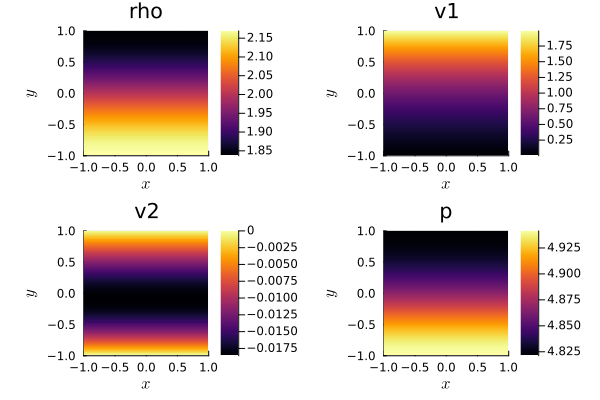

In [138]:
plot(sol, format=:png)